<h1>E-commerce via Computer Vision</h1>

## Raw Scrape of upcitemdb.com

In [1]:
# ENVIRONMENT VARIABLES
PROJECT = 'hidden-layers-llc'
REGION  = 'us-east1'
BUCKET  = 'hidden-layers-llc'
MODULE = 'ai'
COMPONENT = 'images-raw'
GS = 'gs://'

In [2]:
%%bash
gcloud config set project hidden-layers-llc
gcloud config set compute/region us-east1

Updated property [core/project].
Updated property [compute/region].


In [5]:
# ONLY UNCOMMENT AND RUN THIS SCRIPT IF THIS IS THE 1ST NOTEBOOK OPENED IN THIS SESSION
#!bash install_scrape_libs.sh

In [6]:
# import necessary libraries
import time
import os
import requests
from bs4 import BeautifulSoup, SoupStrainer, NavigableString, Comment, Tag
import csv
from copy import deepcopy
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
import pickle as pkl
from shutil import copy2
from orderedset import OrderedSet
from collections import OrderedDict 
from pandas import ExcelWriter
from pandas import ExcelFile
import warnings
warnings.filterwarnings('ignore') # Stop warning about pandas .ix slicing, which is deprecated but most effective

In [7]:
# GLOBAL VARIABLES FOR THIS SITE
# create search combinations
cats = ['Adjustable Wrenches', 'Adjustable Wrench Set']
brands = ['Stanley', 'IRWIN Tools', 'Urrea', 'Proto', 'RIDGID', 'Facom', 'Klein Tools']
search_entries = [brand+' '+cat for brand in brands for cat in cats] # list of normal-Engligh search terms
# known (from Chrome inspection) pre-product-specific page URL path
page_path = 'https://upcitemdb.com/upc'
df_model_rows_list = [] # list to capture all the DataFrames for each column of UPCs 
# desired data field for each image
desired_fields = ['img_no', 'manufacturer', 'description', 'retailer_sku', 'manufacturer_sku', 'img_url', 'img_name']
base_url = 'https://upcitemdb.com'  # set the base_url
site_initials = 'UPC' # create the initials/abbreviation to identify the site
curr_dir = os.getcwd() # set the current directory in which this notebook resides
# create file descriptor (name) for the csv file to which data will be persisted
fid_ProdPages = site_initials+'_'+'scrape'+'_'+'ProdPages'+'.csv' # for the product pages searched next

In [8]:
#retrieve summaries from target site scrape
copy2('../df_pages_CLEAN_pkl.pickle', '.')
copy2('../dir_paths.pickle', '.')
copy2('../brand_dictionary_pkl.pickle', '.')

'./brand_dictionary_pkl.pickle'

In [9]:
# Load the summary DataFrame to map searches on this site to correct labels
with open('df_pages_CLEAN_pkl.pickle', 'rb') as df_pp:
  df_pages = pkl.load(df_pp)

In [10]:
# Load the path details saved from target site scrape
with open('dir_paths.pickle', 'rb') as df_paths:
  home_dir = pkl.load(df_paths)
  project_folder = pkl.load(df_paths)
  target_site_folder = pkl.load(df_paths)
  images_folder = pkl.load(df_paths)
  images_train_folder = pkl.load(df_paths)
  images_validation_folder = pkl.load(df_paths)
  images_test_folder = pkl.load(df_paths)
  classes_list = pkl.load(df_paths)

In [12]:
# Load the brand_dict saved from target site scrape
with open('brand_dictionary_pkl.pickle', 'rb') as brand_dict_fid:
  brand_dict = pkl.load(brand_dict_fid)

In [11]:
# set headers
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)'\
           'AppleWebKit 537.36 (KHTML, like Gecko) Chrome',
           'Accept':'text/html,application/xhtml+xml,application/xml;'\
           'q=0.9,image/webp,*/*;q=0.8'}

In [13]:
df_model_rows = deepcopy(df_pages) # create local mapping to target site classes

In [14]:
df_img_urls = pd.read_excel('UPC_img_urls.xlsx', sheetname='Sheet1') # upload curated data gleaned from this site
upc_cols = ['UPC', 'UPC_A', 'UPC_B', 'UPC_C', 'UPC_D', 'UPC_E', 'UPC_F'] # names of the columns of interest wrt this site
df_names = ['df_0', 'df_A', 'df_B', 'df_C', 'df_D', 'df_E', 'df_F'] # names of the DataFrames/data strucutures to catch each column search

In [17]:
# define a function to clean up df_img_urls
def clean_df_img_urls():
  global df_img_urls
  global upc_cols
  for col in df_img_urls: # Change NaNs to zeroes
    df_img_urls[col].fillna(0, inplace=True)
  for upc_col in upc_cols: # Fix 1st pandas bug: convert UPC columns from floats back to ints 
    df_img_urls[upc_col] = df_img_urls[upc_col].astype('i8')   

In [18]:
# define a function to create separate searches by df_img_urls UPC columns
def create_searches(): # and a data structure for each for audit trail
  global df_model_rows_list
  global df_img_urls
  global upc_cols
  global df_names
  if len(df_model_rows_list) > 0:
    del(df_model_rows_list[:])
  df_names_dict = OrderedDict((df_name, pd.DataFrame()) for df_name in df_names)
  dfs = [df_names_dict[name] for name in df_names]
  for df, upc_col in zip(dfs,upc_cols):
    df[upc_col] = df_img_urls[upc_col]
    df['label'] = df_img_urls['label']
    df_model_rows_list.append(df)

In [19]:
# define a function to retrieve a product page
def get_prod_page_txt(page_url):
  global headers
  session = requests.Session() # Pg. 219
  url = page_url
  req = session.get(url, headers=headers)
  prod_page_txt = req.text
  time.sleep(5)
  
  return prod_page_txt

In [20]:
# define a function to parse for the overall site_dict and the specific site_pages
def get_image_url(prod_page_txt):
  global headers
  bs=BeautifulSoup(prod_page_txt, 'html.parser')
  try:
    img_link = bs.find('img', {'class':'product'})
    img_url = img_link['src']
  except:
    print('could not obtain img_url')
    img_url = 'zero'
  time.sleep(3)
  
  return img_url

In [21]:
# define a function to get and save product image source
def get_image(img_url, df_model_idx, img_label):
  global headers
  global df_model_rows_list
  global df_model_rows
  global site_initials
  session =requests.Session() # Pg. 219
  url = img_url
  req = session.get(url, headers=headers)
  i = Image.open(BytesIO(req.content)) #PIL uses RGB color scheme
  img_no = df_model_rows.loc[df_model_rows['retailer_sku'] == img_label].index[0]
  img_name = site_initials+'_'+'df_'+str(df_model_idx)+'_'+img_label+'.jpg'
  try:
    i.save(img_name)
  except IOError:
    print('Could not save file {} - continuing on'.format(img_name))
    img_name = 'zero'
  
  return img_no, img_name

In [22]:
# define a function to update df_model_rows
def update_df_model_rows(df_model_idx, img_no, img_name):
  global df_model_rows_list
  df = df_model_rows_list[df_model_idx]
  df.ix[img_no, 'img_no'] = img_no
  df.ix[img_no, 'img_name'] = img_name
  print('Just inserted into Dataframe: {} row: {} image: {}'.format(df_model_idx, img_no, img_name))

In [35]:
# define a function to fix pandas bug: convert UPC column with entries of unknown type to a list of integers
def upc_to_list(col):
  upc_list = []
  for item in col:
    upc_list.append(item)
  #upc_list = list(OrderedSet(upc_list))
  
  return upc_list

In [34]:
# define a function to fix pandas bug: convert label column with entries of unknown type to a list of strings
def label_to_list(col):
  label_list = []
  for item in col:
    label_list.append(item)
  #label_list = list(OrderedSet(label_list))
  
  return label_list

In [25]:
# First, fix the 1st pandas bug in df_img_urls
clean_df_img_urls()

In [27]:
# Second, do the same wrt labels
labels = label_to_list(df_img_urls['label'].tolist())

In [29]:
# Third, create the searches by UPC column and a data structure to capture each for audit trail
create_searches()  # The data members of these data structures will still need pandas debugging below

In [37]:
# run the searches
for df_idx, df in enumerate(df_model_rows_list):
  upc_col_name = df.columns[0]
  print('upc_col_name: '.format(upc_col_name))
  upcs = upc_to_list(df[upc_col_name].tolist()) # Even with the above pandas bug repairs,
  print('df idx: {}'.format(df_idx))      # column entries may still be lists of indeterminate types
  for upc_idx, upc in enumerate(upcs):
    if isinstance(upc, int) and upc > 0: # Still need to avoid, e.g., leftover EOL (/n) chars
      time.sleep(4)                     # and should skip any row without a UPC
      img_label = labels[upc_idx]
      print('upc: {} label: {}'.format(upc, img_label))
      page_url = page_path + '/' + str(upc)
      print('page_url: {}'.format(page_url))
      try:
        prod_page_txt = get_prod_page_txt(page_url)
      except:
        print('Could not obtain prod_page_txt')
        continue
      try:
        img_url = get_image_url(prod_page_txt)
      except:
        print('Could not obtain img_url')
        continue
      if img_url != 'zero':
        try:
          img_no, img_name = get_image(img_url, df_idx, img_label)
        except:
          print('Could not obtain img')
          continue
      if img_name != 'zero':
        try:
          update_df_model_rows(df_idx, img_no, img_name)
        except:
          print ('Could not save img_no and img_name')

upc_col_name: 
df idx: 0
upc: 76174873672 label: SNY_87-367
page_url: https://upcitemdb.com/upc/76174873672
Just inserted into Dataframe: 0 row: 2 image: UPC_df_0_SNY_87-367.jpg
upc: 76174874716 label: SNY_87-471
page_url: https://upcitemdb.com/upc/76174874716
Just inserted into Dataframe: 0 row: 0 image: UPC_df_0_SNY_87-471.jpg
upc: 38548028293 label: IRW_BM2078608
page_url: https://upcitemdb.com/upc/38548028293
Just inserted into Dataframe: 0 row: 12 image: UPC_df_0_IRW_BM2078608.jpg
upc: 38548028286 label: IRW_BM2078606
page_url: https://upcitemdb.com/upc/38548028286
Just inserted into Dataframe: 0 row: 11 image: UPC_df_0_IRW_BM2078606.jpg
upc: 76174909487 label: SNY_90-948
page_url: https://upcitemdb.com/upc/76174909487
Just inserted into Dataframe: 0 row: 5 image: UPC_df_0_SNY_90-948.jpg
upc: 76174874730 label: SNY_87-473
page_url: https://upcitemdb.com/upc/76174874730
Just inserted into Dataframe: 0 row: 1 image: UPC_df_0_SNY_87-473.jpg
upc: 660731618587 label: URR_708S
page_url:

upc: 787721795339 label: SNY_90-948
page_url: https://upcitemdb.com/upc/787721795339
Just inserted into Dataframe: 3 row: 5 image: UPC_df_3_SNY_90-948.jpg
upc: 794777665585 label: IRW_BM2078612
page_url: https://upcitemdb.com/upc/794777665585
Just inserted into Dataframe: 3 row: 14 image: UPC_df_3_IRW_BM2078612.jpg
upc_col_name: 
df idx: 4
upc: 789474948468 label: IRW_BM2078608
page_url: https://upcitemdb.com/upc/789474948468
Just inserted into Dataframe: 4 row: 12 image: UPC_df_4_IRW_BM2078608.jpg
upc: 80850306880 label: IRW_BM2078612
page_url: https://upcitemdb.com/upc/80850306880
Just inserted into Dataframe: 4 row: 14 image: UPC_df_4_IRW_BM2078612.jpg
upc_col_name: 
df idx: 5
upc: 756655742481 label: IRW_BM2078608
page_url: https://upcitemdb.com/upc/756655742481
Just inserted into Dataframe: 5 row: 12 image: UPC_df_5_IRW_BM2078608.jpg
upc: 43953494052 label: IRW_BM2078612
page_url: https://upcitemdb.com/upc/43953494052
Just inserted into Dataframe: 5 row: 14 image: UPC_df_5_IRW_BM2

In [41]:
# Now let's capture some essentials before persisting images to train sudirectory
current_folder = deepcopy(os.getcwd())
current_dir_contents = os.listdir(current_folder)
img_fids = [fid for fid in current_dir_contents if fid.endswith('.jpg')]
mode = images_train_folder
classes = [fid[9:].rstrip('.jpg') for fid in img_fids]

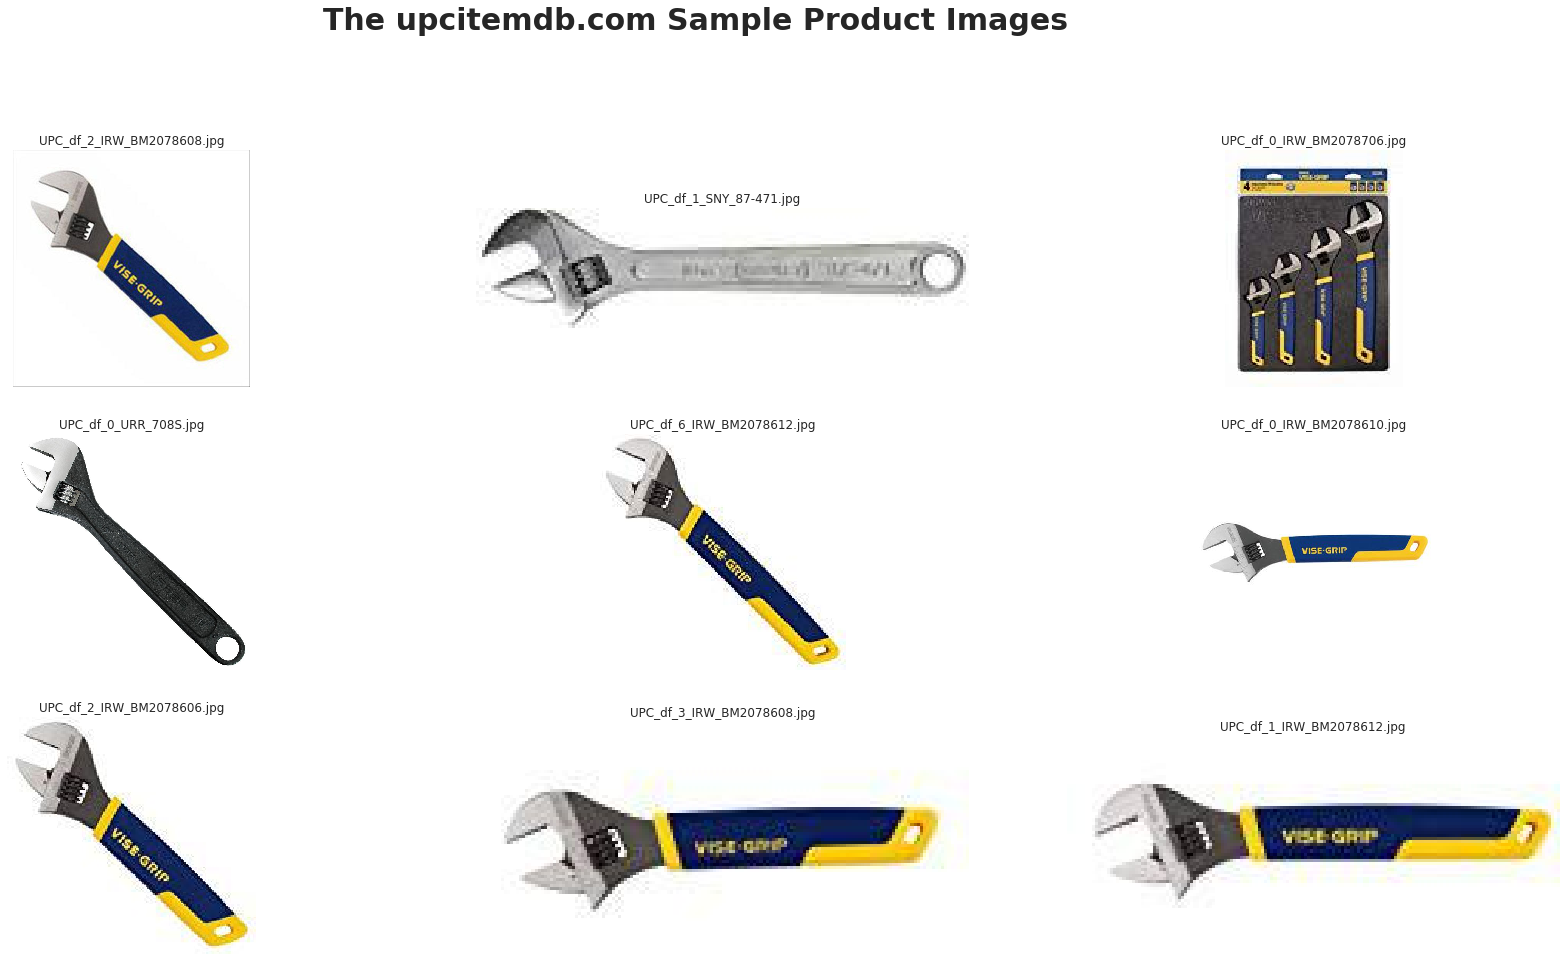

In [46]:
# Now, let's view those images
#plt.clf()  # No need to call this now, as last plot didn't call .show()
images_sample = []
img_tags = []
img_cnt = len(img_fids)
img_idxs = np.arange(0, img_cnt, 7)
sample_fids = [img_fids[img_idx] for img_idx in img_idxs]

for img_name in sample_fids:
  img=cv2.imread(img_name) # Use cv2.imread, which doesn't change color scheme
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Site's images in BGR
  images_sample.append(img)
  img_tags.append(img_name)

sample_cnt = len(images_sample)

plt.figure(figsize=(30,20))
plt.suptitle('The upcitemdb.com Sample Product Images', fontsize=30, weight='bold')
for i in range(sample_cnt):
    plt.subplot(431 + i)
    plt.title(img_tags[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample[i])

plt.show()

In [47]:
# Let's check some metadata for each sampled image to know what we have
for img_no, image in enumerate(images_sample):
  print('for img_no: {} the shape is: {}'.format(img_no, image.shape))
  print('for img_no: {} the type is: {}'.format(img_no, type(image)))

for img_no: 0 the shape is: (450, 450, 3)
for img_no: 0 the type is: <class 'numpy.ndarray'>
for img_no: 1 the shape is: (39, 160, 3)
for img_no: 1 the type is: <class 'numpy.ndarray'>
for img_no: 2 the shape is: (160, 120, 3)
for img_no: 2 the type is: <class 'numpy.ndarray'>
for img_no: 3 the shape is: (1000, 1000, 3)
for img_no: 3 the type is: <class 'numpy.ndarray'>
for img_no: 4 the shape is: (154, 160, 3)
for img_no: 4 the type is: <class 'numpy.ndarray'>
for img_no: 5 the shape is: (450, 450, 3)
for img_no: 5 the type is: <class 'numpy.ndarray'>
for img_no: 6 the shape is: (152, 160, 3)
for img_no: 6 the type is: <class 'numpy.ndarray'>
for img_no: 7 the shape is: (74, 160, 3)
for img_no: 7 the type is: <class 'numpy.ndarray'>
for img_no: 8 the shape is: (65, 160, 3)
for img_no: 8 the type is: <class 'numpy.ndarray'>


In [51]:
# save off the cleaned, FINAL DataFrame
with open('df_UPC_CLEAN_pkl.pickle', 'wb') as df_pages_clean:
  for df in df_model_rows_list:
    pkl.dump(df, df_pages_clean, protocol=pkl.HIGHEST_PROTOCOL)

In [49]:
for pic_class, fid in zip(classes, img_fids):
  copy2(fid, os.path.join('..', mode, pic_class))

## On to the next site to build our database